# Password Strength Estimation Model (Evaluation)

In [11]:
!pip install torch transformers matplotlib

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [12]:
import string
import torch
import numpy as np
from transformers import GPT2LMHeadModel, RobertaTokenizerFast
import matplotlib.pyplot as plt
from matplotlib.patches import Wedge


# Model and Tokenizer Configuration

Here we will load the model and tokenizer that we saved in the previous notebook. 

In [13]:
# CONSTANTS
TOKENIZER_PATH = "./uniqpass-v16-passwords-tokenizer/"
MODEL_PATH = "./uniqpass-v16-passwords-trained/last"
MAXCHARS = 16
DEVICE = 'cpu'

# Check if MPS is available and set it as the default device
if torch.backends.mps.is_available():
    DEVICE = torch.device("mps")

print(f"Using device: {DEVICE}")

# Load the tokenizer from the model path
tokenizer = RobertaTokenizerFast.from_pretrained(TOKENIZER_PATH, 
                                                max_len=MAXCHARS+2,
                                                padding="max_length", 
                                                truncation=True,
                                                do_lower_case=False,
                                                strip_accents=False,
                                                mask_token="<mask>",
                                                unk_token="<unk>",
                                                pad_token="<pad>",
                                                truncation_side="right")

# Load model
model = GPT2LMHeadModel.from_pretrained(MODEL_PATH).eval().to(DEVICE)

Using device: mps


# Conditional Generation from Template Groups

We can setup the model to only generate passwords that meet a set of heuristic controls. In this case im using lowercase, uppercase, digits and punctuation.

This can be extended to include/excluded certain words, length enforcement and much more.

In [14]:
def get_tokens(tokenizer, symbols):
    return tokenizer(symbols, add_special_tokens=False).input_ids

def create_token_dict(tokenizer):
    lowercase = list(string.ascii_lowercase)
    uppercase = list(string.ascii_uppercase)
    digits = list(string.digits)
    punctuation = list(string.punctuation)
    
    lowercase_tokens = get_tokens(tokenizer, lowercase)
    uppercase_tokens = get_tokens(tokenizer, uppercase)
    digits_tokens = get_tokens(tokenizer, digits)
    punctuation_tokens = get_tokens(tokenizer, punctuation)
    
    return {
        "l": lowercase_tokens,
        "u": uppercase_tokens,
        "d": digits_tokens,
        "p": punctuation_tokens
    }

def conditional_generation(template, num_generations=1):
    generated = 0
    generations = []
    
    while generated < num_generations:
        generation = torch.tensor([tokenizer.bos_token_id]).unsqueeze(0)
        current_length = 1

        for char in template:
            if char in token_dict:
                bad_tokens = [i for i in all_tokens if i not in token_dict[char]]
            else:
                bad_tokens = [[tokenizer.eos_token_id]]
            
            generation = model.generate(generation.to(DEVICE), do_sample=True, max_length=current_length+1, pad_token_id=tokenizer.pad_token_id, num_return_sequences=1,  bad_words_ids=bad_tokens)
            current_length += 1
        
        if not 2 in generation.flatten():
            generations.append(generation)
            generated += 1
    
    return torch.cat(generations, 0)[:, 1:]

# Extract Log Likelihoods from Generated Passwords

The log likelihood of a password is the probability of that password being generated by the model. The higher the log likelihood, the more likely the password is to be generated by the model.

For this case we generally see generations with `-1` to `-10` as weaker and already known, where as `-30` to `-40` are more likely to be unique and stronger.

This is directly reflecting the entropy of the password, and the more entropy the more secure and random the password is.

In [15]:
def calculate_password_probability(model, tokenizer, password, device):
    # Tokenize the password and convert to tensor format
    input_ids = tokenizer.encode(password, return_tensors="pt").to(device)
    
    # Get the model's logit predictions for the password
    with torch.no_grad():
        outputs = model(input_ids)
        logits = outputs.logits
    
    # Convert logits to log probabilities
    log_probabilities = torch.nn.functional.log_softmax(logits, dim=-1)
    
    # Gather the log probabilities of the actual tokens
    selected_log_probs = log_probabilities[:, :-1].gather(2, input_ids[:, 1:].unsqueeze(-1)).squeeze(-1)
    
    # Sum the log probabilities
    total_log_probability = selected_log_probs.sum().item()
    
    return total_log_probability


# Use Generator and create a sample test set

Here we utilize the generator to create a sample test set. Additionally you can extend with known passwords to help ensure the proper probability distribution get represented for known features that the model was trained on.

In [16]:
token_dict = create_token_dict(tokenizer)
all_tokens = [[i] for i in range(len(tokenizer))]

generations = conditional_generation("ululp**dd", 3)

decoded_passwords = tokenizer.batch_decode(generations)

# Add some common passwords to the list to ensure known results rank higher in log likelihood
decoded_passwords.append("password")
decoded_passwords.append("password1")
decoded_passwords.append("password123")
decoded_passwords.append("12345")
decoded_passwords.append("123456")
decoded_passwords.append("12345678")
decoded_passwords.append("123456789")
decoded_passwords.append("qwerty")
decoded_passwords.append("abc123")
decoded_passwords.append("iloveyou")
decoded_passwords.append("111111")

log_likelihoods = []
for i, password in enumerate(decoded_passwords):
    password_probability = calculate_password_probability(model, tokenizer, password, DEVICE)
    log_likelihoods.append(password_probability)
    print(f"Generated Password {i+1}: {password} - Log Likelihood: {password_probability}")

Generated Password 1: WuRi@fu45 - Log Likelihood: -39.63685607910156
Generated Password 2: JiIh)EN28 - Log Likelihood: -43.6879997253418
Generated Password 3: MiPt@un12 - Log Likelihood: -38.6212272644043
Generated Password 4: password - Log Likelihood: -9.068122863769531
Generated Password 5: password1 - Log Likelihood: -10.289379119873047
Generated Password 6: password123 - Log Likelihood: -11.009557723999023
Generated Password 7: 12345 - Log Likelihood: -11.53687858581543
Generated Password 8: 123456 - Log Likelihood: -10.188579559326172
Generated Password 9: 12345678 - Log Likelihood: -10.596012115478516
Generated Password 10: 123456789 - Log Likelihood: -9.075552940368652
Generated Password 11: qwerty - Log Likelihood: -9.974020004272461
Generated Password 12: abc123 - Log Likelihood: -10.744060516357422
Generated Password 13: iloveyou - Log Likelihood: -10.05469799041748
Generated Password 14: 111111 - Log Likelihood: -11.168460845947266


# Visualize the Results

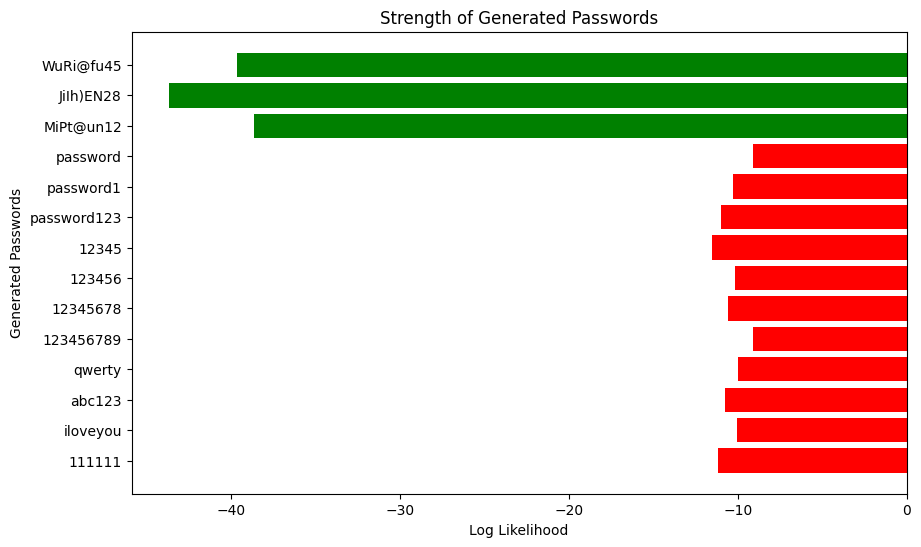

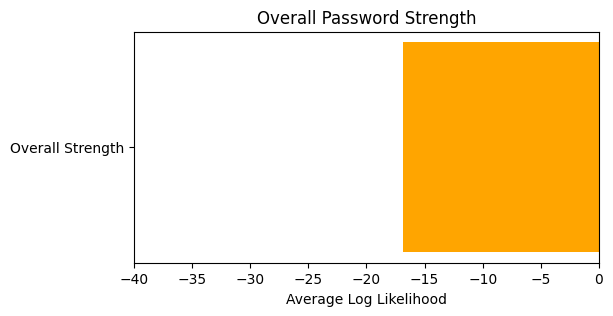

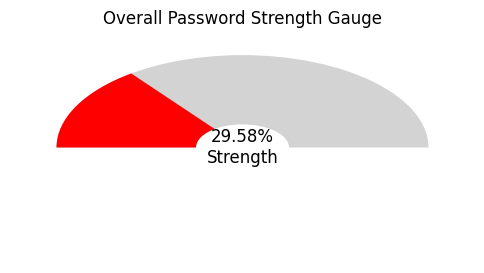

In [17]:
# Determining colors based on strength (log likelihood)
colors = []
for ll in log_likelihoods:
    if ll < -20:
        colors.append('green')  # Strong
    elif ll < -15:
        colors.append('orange')  # Medium
    else:
        colors.append('red')  # Weak

# Creating the horizontal bar plot
plt.figure(figsize=(10, 6))
bars = plt.barh(decoded_passwords, log_likelihoods, color=colors)

# Adding labels and title
plt.xlabel('Log Likelihood')
plt.ylabel('Generated Passwords')
plt.title('Strength of Generated Passwords')

# Invert y-axis to have the highest value on top
plt.gca().invert_yaxis()

# save plots to file in ./docs
plt.savefig('./docs/strength_of_generated_passwords.png')

# Show the plot
plt.show()


# Overall strength gauge (average of log likelihoods)
overall_strength = np.mean(log_likelihoods)
strength_color = 'green' if overall_strength < -20 else 'orange' if overall_strength < -15 else 'red'

plt.figure(figsize=(6, 3))
plt.barh('Overall Strength', overall_strength, color=strength_color)
plt.xlabel('Average Log Likelihood')
plt.title('Overall Password Strength')
plt.xlim([-40, 0])  # Assuming log likelihood ranges from -40 to 0
# save plots to file in ./docs
plt.savefig('./docs/overall_log_likelihood.png')
plt.show()
  
# Function to convert log likelihood to a strength percentage
def log_likelihood_to_strength_percentage(log_likelihood):
    min_log_likelihood = -45  # corresponds to 100%
    max_log_likelihood = -5  # corresponds to 0%

    # Ensure the log likelihood is within the range we're considering
    log_likelihood = max(min_log_likelihood, min(max_log_likelihood, log_likelihood))

    # Calculate the percentage
    strength_percentage = (
        1
        - (log_likelihood - min_log_likelihood)
        / (max_log_likelihood - min_log_likelihood)
    ) * 100

    return strength_percentage
  
strengths = [log_likelihood_to_strength_percentage(ll) for ll in log_likelihoods]

# Calculate the overall strength as an average of individual strengths
overall_strength = sum(strengths) / len(strengths)

# Plotting a half-donut gauge for overall strength
fig, ax = plt.subplots(figsize=(6, 3), subplot_kw={'aspect': 'auto'})

# Creating the half-donut chart
wedge = Wedge((0.5, 0.5), 0.4, 0, 180, width=0.3, facecolor='lightgray')
ax.add_artist(wedge)

# Indicator for overall strength
strength_color = 'green' if overall_strength > 66 else 'orange' if overall_strength > 33 else 'red'
wedge_strength = Wedge((0.5, 0.5), 0.4, 180 - overall_strength / 100 * 180, 180, width=0.3, facecolor=strength_color)
ax.add_artist(wedge_strength)

# Remove axis
ax.axis('off')

# Adding text
plt.text(0.5, 0.5, f'{overall_strength:.2f}%\nStrength', horizontalalignment='center', verticalalignment='center', fontsize=12)

# Set title
plt.title("Overall Password Strength Gauge")

# save plots to file in ./docs
plt.savefig('./docs/overall_strength_gauge.png')

# Show the plot
plt.show()
